In [1]:
%matplotlib inline
%reload_ext blackcellmagic

In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
from concorde.tsp import TSPSolver
mpl.rcParams['agg.path.chunksize'] = 10000  # Needed to allow plotting the large paths.

## Loading the data

The path length will depend on the primality of the citiy IDs, so we need an efficient way to check for this. Lets precompute this for every city, and tag it along the data frame.

In [2]:
cities = pd.read_csv(os.path.join("data", "cities.csv"))
cities["prime"] = cities.CityId.apply(sympy.isprime)
print(f"We have {len(cities)} cities to visit.")
cities.head(6)

We have 197769 cities to visit.


CityId            X            Y  prime
0       0   316.836739  2202.340707  False
1       1  4377.405972   336.602082  False
2       2  3454.158198  2820.053011   True
3       3  4688.099298  2935.898056   True
4       4  1010.696952  3236.750989  False
5       5  2474.230877  1435.514651   True

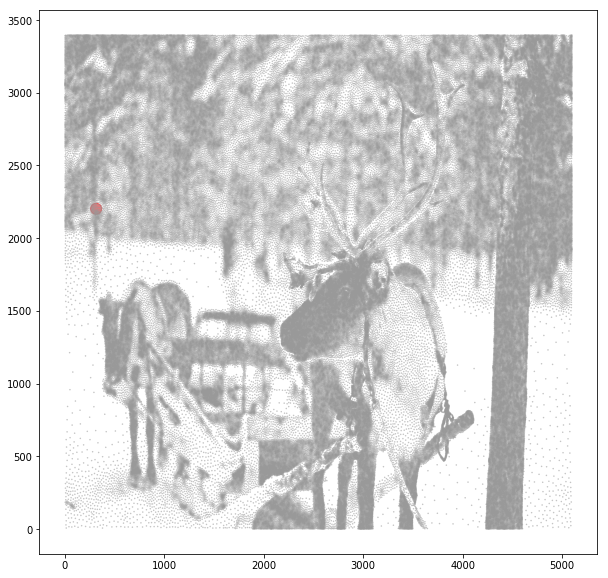

In [3]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(
    cities["X"],
    cities["Y"],
    marker=".",
    c=(cities.CityId != 0).astype(int),
    cmap="Set1",
    alpha=0.6,
    s=500 * (cities.CityId == 0).astype(int) + 1,
)
plt.show()

The red dot is the north pole, and each other dot is a city.

## Representing a path

In [4]:
class Path(object):
    def __init__(self, seq, cities=cities):
        self.path = seq
        self.cities = cities

        # A list of primes is used in the length computation in order to
        # make this _much_ faster. Precomputed at init (takes very little time).
        self.prime_numbers = [i for i in sympy.primerange(0, len(self.cities) + 1)]

        assert self.path[0] == self.path[-1] == 0  # Start and end at the pole.
        assert len(set(self.path)) == len(self.path) - 1 == len(self.cities)

    @property
    def length(self):
        """Returns the total distance of this path."""
        path_df = self.cities.reindex(self.path).reset_index()

        path_df["step"] = np.sqrt(
            (path_df.X - path_df.X.shift()) ** 2 + (path_df.Y - path_df.Y.shift()) ** 2
        )
        path_df["step_adj"] = np.where(
            (path_df.index) % 10 != 0,
            path_df.step,
            path_df.step
            + path_df.step * 0.1 * (~path_df.CityId.shift().isin(self.prime_numbers)),
        )
        return path_df.step_adj.sum()

    def plot_path(self, length=None):
        if length is None:
            length = len(self.cities)
        df_path = self.cities.reindex(self.path).head(length)
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.plot(df_path["X"], df_path["Y"])


    def make_submission(self, filename="submission.csv"):
        df = pd.DataFrame(data={"Path": self.path})
        df.to_csv(os.path.join("submissions", filename), index=False)


## Nearest Neighbors

In [5]:
def nearest_neighbour(cities):
    ids = cities.CityId.values[1:]  # Exclude north pole, it's position is fixed.
    xy = np.array([cities.X.values, cities.Y.values]).T[1:]
    path = [0]
    while len(ids) > 0:
        last_xy = np.array([cities.X[path[-1]], cities.Y[path[-1]]])

        # Compute (squared) Euclidian distance to every other point
        dist = np.sum((xy - last_xy) ** 2, axis=1)
        nearest_index = np.argmin(dist)
        path.append(ids[nearest_index])

        # Now remove the city from ids and xy (to avoid duplicates).
        ids = np.delete(ids, nearest_index, axis=0)
        xy = np.delete(xy, nearest_index, axis=0)
    return Path(path + [0], cities)

Nearest Neighbors score: 1,812,602.1861388024


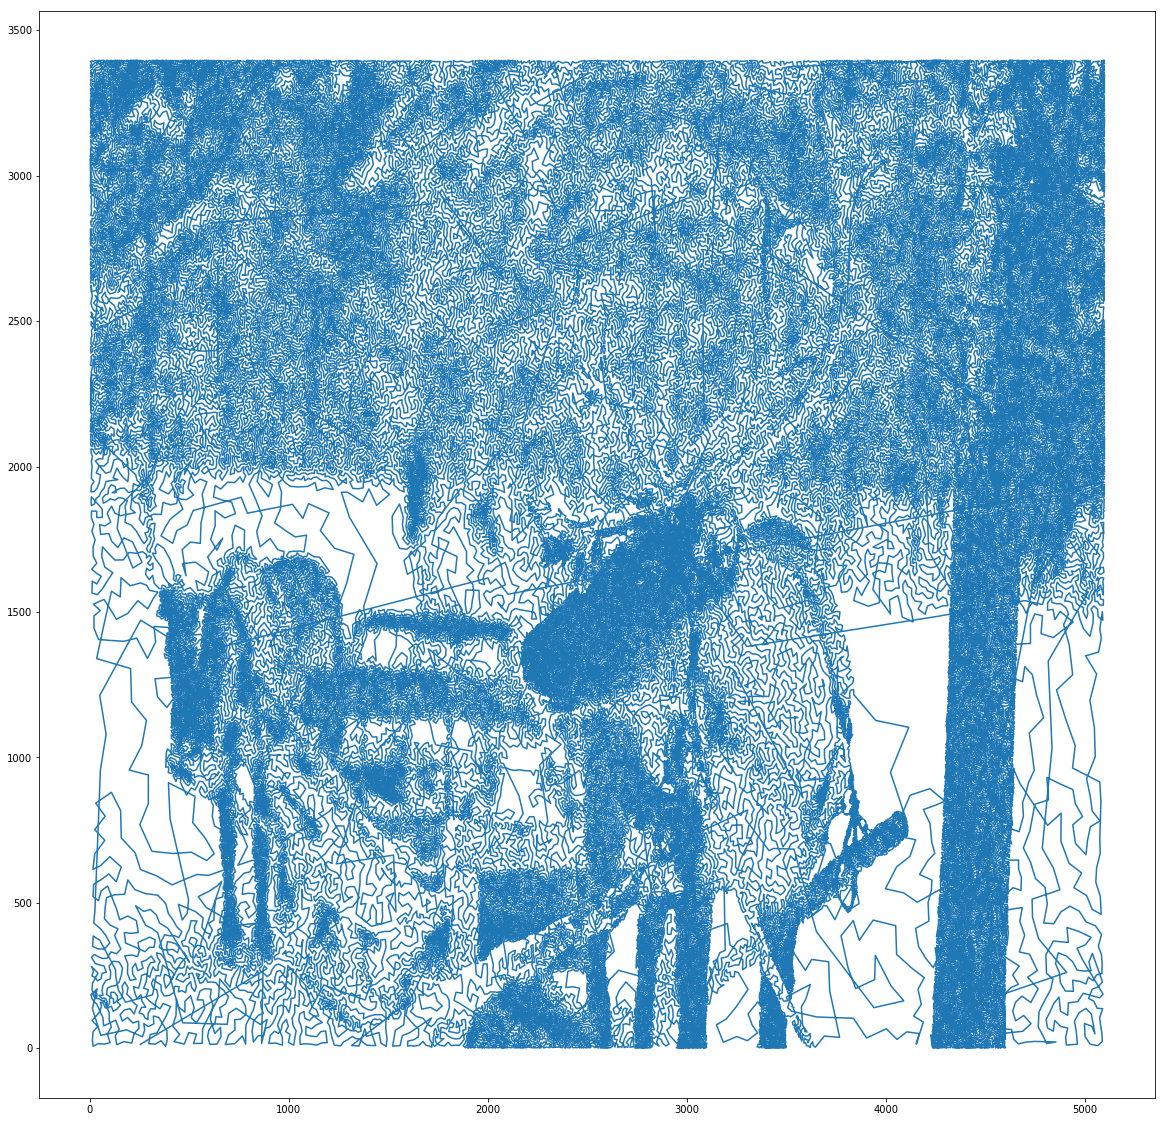

In [126]:
nearest_neighbour_path = nearest_neighbour(cities)
print(f"Nearest Neighbors score: {nearest_neighbour_path.length:,}")
nearest_neighbour_path.plot_path()

In [6]:
nearest_neighbour_path.make_submission("nearest_neighbours_plain.csv")

## Concorde Solver

In [13]:
def concorde_solver(cities, random_seed=2019):
    solver = TSPSolver.from_data(cities.X,cities.Y,norm="EUC_2D")
    tour_data = solver.solve(time_bound = 60.0, verbose = True, random_seed = 2019)
    return Path(np.append(tour_data.tour, [0]), cities) if tour_data.found_tour else None

Concorde score: 1,533,026.060142757


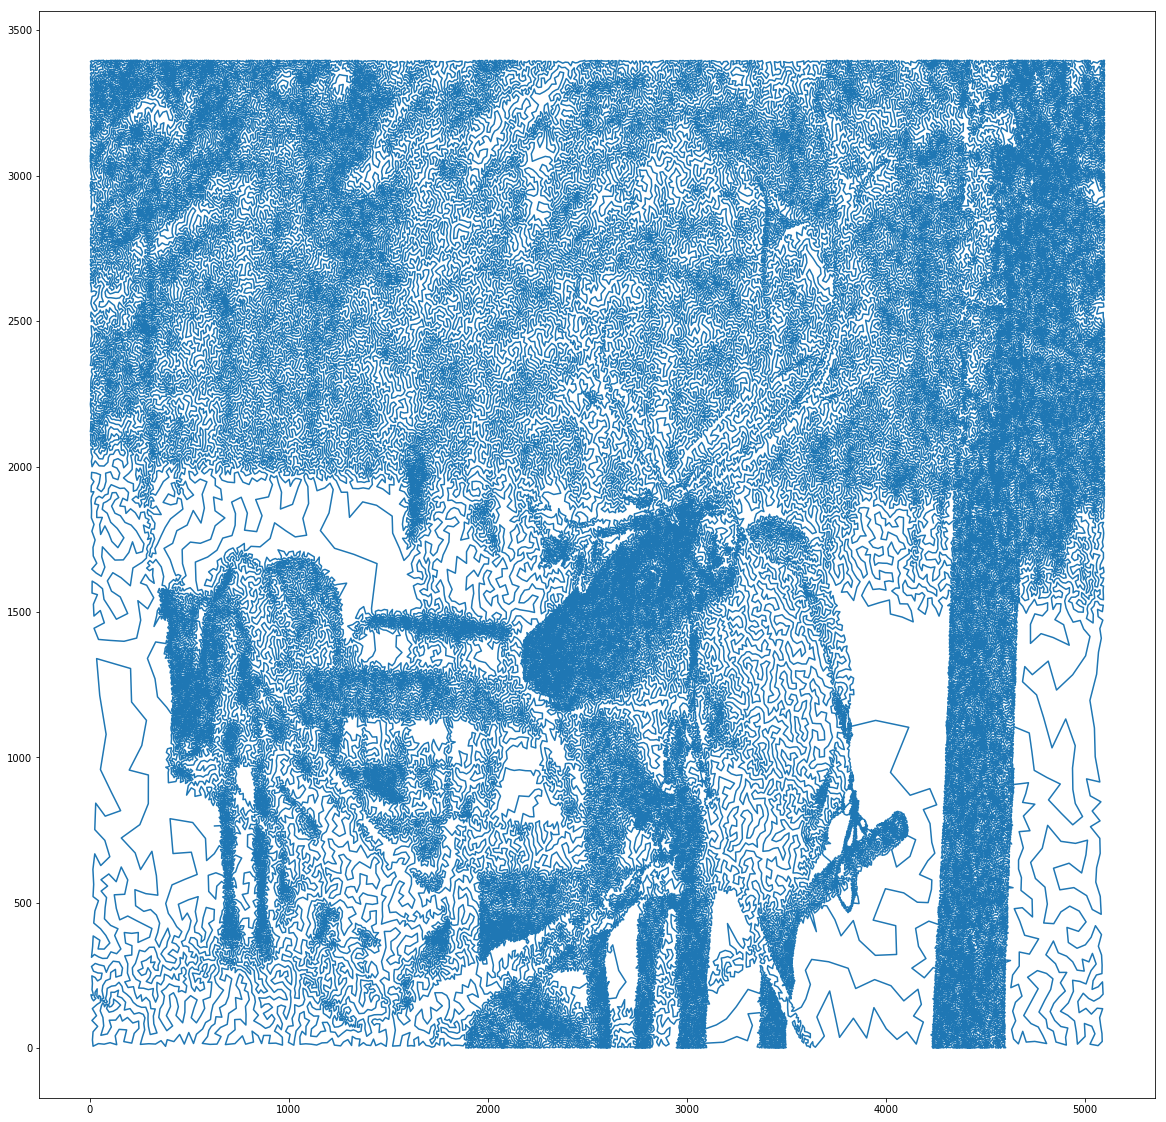

In [15]:
concorde_path = concorde_solver(cities, random_seed=1234)
print(f"Concorde score: {concorde_path.length:,}")
concorde_path.make_submission("concorde_path.csv")
concorde_path.plot_path()